In [8]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xgboost as xgb


In [9]:
# Loadind the data
df = pd.read_csv("/Users/parthgajera/Documents/Thesis_Data/LI-Small_Trans.csv")

In [10]:
print(df.head(5))

          Timestamp  From Bank    Account  To Bank  Account.1  \
0  2022/09/01 00:08         11  8000ECA90       11  8000ECA90   
1  2022/09/01 00:21       3402  80021DAD0     3402  80021DAD0   
2  2022/09/01 00:00         11  8000ECA90     1120  8006AA910   
3  2022/09/01 00:16       3814  8006AD080     3814  8006AD080   
4  2022/09/01 00:00         20  8006AD530       20  8006AD530   

   Amount Received Receiving Currency  Amount Paid Payment Currency  \
0       3195403.00          US Dollar   3195403.00        US Dollar   
1          1858.96          US Dollar      1858.96        US Dollar   
2        592571.00          US Dollar    592571.00        US Dollar   
3            12.32          US Dollar        12.32        US Dollar   
4          2941.56          US Dollar      2941.56        US Dollar   

  Payment Format  Is Laundering  
0   Reinvestment              0  
1   Reinvestment              0  
2         Cheque              0  
3   Reinvestment              0  
4   Reinvest

In [11]:
# Convert timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [12]:
# Core Feature Engineering
df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['SameBank'] = (df['From Bank'] == df['To Bank']).astype(int)
df['SameAccount'] = (df['Account'] == df['To Bank']).astype(int)
df['CurrencyMismatch'] = (df['Receiving Currency'] != df['Payment Currency']).astype(int)

In [13]:

# Frequency of transactions per account
df['Txn Count From Account'] = df.groupby('Account')['Timestamp'].transform('count')

# Rolling average of amounts from each account
df['Rolling Avg From Account'] = df.sort_values(by='Timestamp') \
    .groupby('Account')['Amount Paid'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# Final Features for Modeling
features = [
    'Amount Received',
    'Amount Paid',
    'SameBank',
    'SameAccount',
    'CurrencyMismatch',
    'Txn Count From Account',
    'Rolling Avg From Account',
    'Payment Format'
]

X = df[features]

#'Hour','DayOfWeek',

In [ ]:

'''preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Payment Format']),
    ],
    remainder='passthrough'
)

# Isolation Forest pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('iso_forest', IsolationForest(contamination='auto', random_state=42))
])

# Fit model
pipeline.fit(X)

# Predict anomaly scores and labels
X_transformed = pipeline.named_steps['preprocess'].transform(X)
df['anomaly_score'] = pipeline.named_steps['iso_forest'].decision_function(X_transformed)
df['anomaly_label'] = pipeline.named_steps['iso_forest'].predict(X_transformed)
df['anomaly_label'] = df['anomaly_label'].map({1: 'Normal', -1: 'Anomaly'})

# Output the flagged anomalies
anomalies = df[df['anomaly_label'] == 'Anomaly']
print(anomalies[['Timestamp', 'Account', 'Amount Paid', 'anomaly_score']]) '''

In [14]:
# --------------------------------------------
# 2. Building of the pipeline for Isolation Forest
# --------------------------------------------
# One-hot encode Payment Format while leaving the other features unchanged.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Payment Format']),
    ],
    remainder='passthrough'
)

# pipeline with preprocessing and the Isolation Forest
iso_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('iso_forest', IsolationForest(contamination='auto', random_state=42))
])

# Fit the model on X
iso_pipeline.fit(X)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Payment Format'])])),
                ('iso_forest', IsolationForest(random_state=42))])

In [15]:
# --------------------------------------------
# 3. Anomaly scores and labels from Isolation Forest
# --------------------------------------------
# Transform X (apply one-hot encoding on 'Payment Format' and passthrough other features)
X_transformed = iso_pipeline.named_steps['preprocess'].transform(X)

# Compute the anomaly score and assign the output label
df['anomaly_score'] = iso_pipeline.named_steps['iso_forest'].decision_function(X_transformed)
df['anomaly_label'] = iso_pipeline.named_steps['iso_forest'].predict(X_transformed)

# Map labels from {1, -1} to more interpretable strings if needed
df['anomaly_label'] = df['anomaly_label'].map({1: 'Normal', -1: 'Anomaly'})

# Print the rows flagged as anomalies by Isolation Forest
anomalies = df[df['anomaly_label'] == 'Anomaly']
print("\nIsolation Forest flagged anomalies:")
print(anomalies[['Timestamp', 'Account', 'Amount Paid', 'anomaly_score']])


Isolation Forest flagged anomalies:
                  Timestamp    Account   Amount Paid  anomaly_score
0       2022-09-01 00:08:00  8000ECA90  3.195403e+06      -0.111551
70      2022-09-01 00:11:00  800BC6AF0  1.107319e+06      -0.086837
77      2022-09-01 00:21:00  800BDE650  5.329268e+06      -0.041587
80      2022-09-01 00:29:00  800BDE650  3.204100e+03      -0.018377
97      2022-09-01 00:21:00  800BE94E0  2.496595e+06      -0.102058
...                     ...        ...           ...            ...
6924023 2022-09-10 23:56:00  803A93631  1.000000e-02      -0.075556
6924027 2022-09-10 23:46:00  10042BA51  2.118480e-01      -0.010048
6924035 2022-09-10 23:30:00  10042BA51  3.661940e-01      -0.012714
6924036 2022-09-10 23:59:00  10042BA51  5.755200e-02      -0.002424
6924037 2022-09-10 23:45:00  10042BA51  1.623860e-01      -0.008461

[693111 rows x 4 columns]


In [ ]:
# --------------------------------------------
# 4. Set up Hybrid Model with XGBoost
# --------------------------------------------
# The Isolation Forest label as a pseudo target for the XGBoost classifier.
# Binary target: 1 for Anomaly, 0 for Normal.
label_map = {'Anomaly': 1, 'Normal': 0}
df['hybrid_label'] = df['anomaly_label'].map(label_map)

# New feature set for the supervised step.
# 'Payment Format' is left out here because its encoded version is used by the pipeline;
hybrid_features = [
    'Amount Received',
    'Amount Paid',
    'SameBank',
    'SameAccount',
    'CurrencyMismatch',
    'Txn Count From Account',
    'Rolling Avg From Account',
    'anomaly_score'  # additional feature from Isolation Forest
]

X_hybrid = df[hybrid_features]
y_hybrid = df['hybrid_label']

#spliting of the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_hybrid, y_hybrid, test_size=0.2, random_state=42, stratify=y_hybrid)

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the hybrid XGBoost model
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_test)
print("\nClassification Report for the Hybrid Model (XGBoost):")
print(classification_report(y_test, y_pred))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:12:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report for the Hybrid Model (XGBoost):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1246188
           1       1.00      1.00      1.00    138622

    accuracy                           1.00   1384810
   macro avg       1.00      1.00      1.00   1384810
weighted avg       1.00      1.00      1.00   1384810



In [ ]:
# --------------------------------------------
# 5. Hybrid Model Predictions
# --------------------------------------------
df['hybrid_prediction'] = xgb_model.predict(X_hybrid)
df['hybrid_prediction'] = df['hybrid_prediction'].map({1: 'Anomaly', 0: 'Normal'})

print("\nSample of Hybrid Model Predictions:")
print(df[['Timestamp', 'Account', 'Amount Paid', 'anomaly_score','Is Laundering', 'hybrid_prediction']])





Sample of Hybrid Model Predictions:
                  Timestamp    Account   Amount Paid  anomaly_score  \
0       2022-09-01 00:08:00  8000ECA90  3.195403e+06      -0.111551   
1       2022-09-01 00:21:00  80021DAD0  1.858960e+03       0.076462   
2       2022-09-01 00:00:00  8000ECA90  5.925710e+05       0.092088   
3       2022-09-01 00:16:00  8006AD080  1.232000e+01       0.080821   
4       2022-09-01 00:00:00  8006AD530  2.941560e+03       0.027869   
...                     ...        ...           ...            ...   
6924044 2022-09-10 23:39:00  81B2518F1  3.346900e-02       0.060163   
6924045 2022-09-10 23:48:00  81B567481  1.313000e-03       0.054643   
6924046 2022-09-10 23:50:00  81B567481  1.305800e-02       0.056458   
6924047 2022-09-10 23:57:00  81A2206B1  4.145370e-01       0.049091   
6924048 2022-09-10 23:31:00  81A2206B1  3.427700e-02       0.060462   

         Is Laundering hybrid_prediction  
0                    0           Anomaly  
1                    0  

In [ ]:
print(df[df['Is Laundering'] == 1])

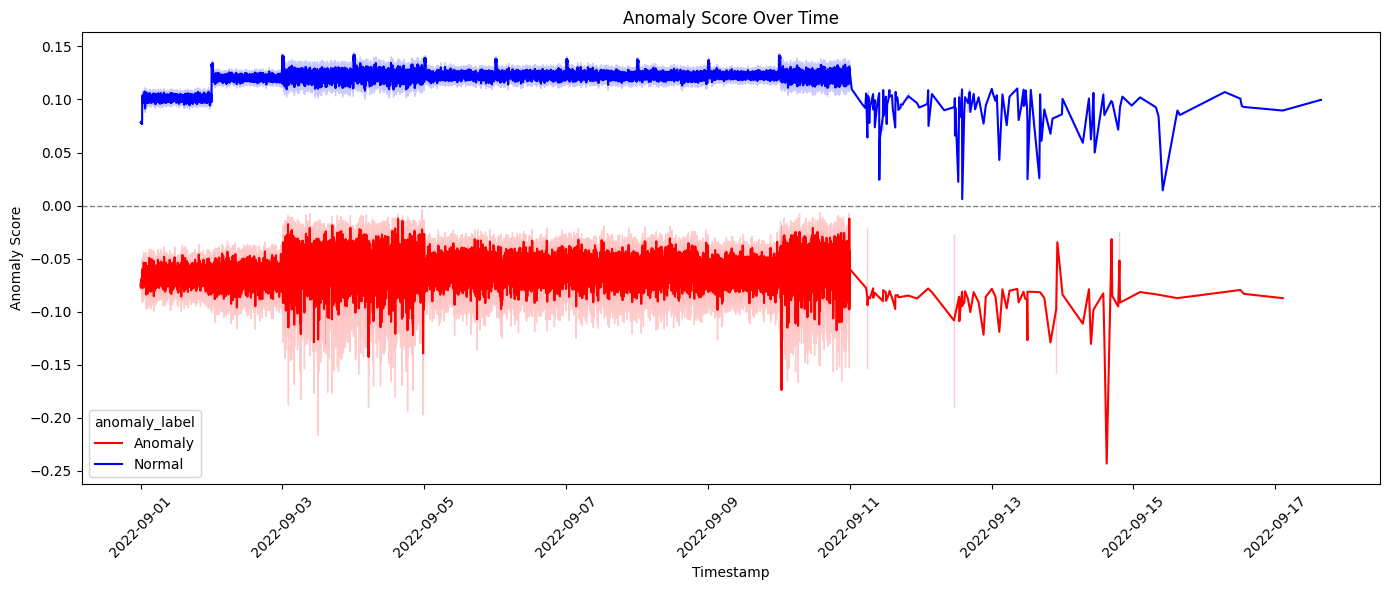

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.lineplot(data=df, x='Timestamp', y='anomaly_score', hue='anomaly_label', palette={'Normal': 'blue', 'Anomaly': 'red'})
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.title('Anomaly Score Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Anomaly Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df['anomaly_score'], bins=50, kde=True, color='purple')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', label='Anomaly Threshold')
plt.legend()
plt.show()


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_transformed)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=df['anomaly_label'], palette={'Normal': 'gray', 'Anomaly': 'red'})
plt.title('PCA Visualization of Anomalies')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()
